Plotting chart with markers...


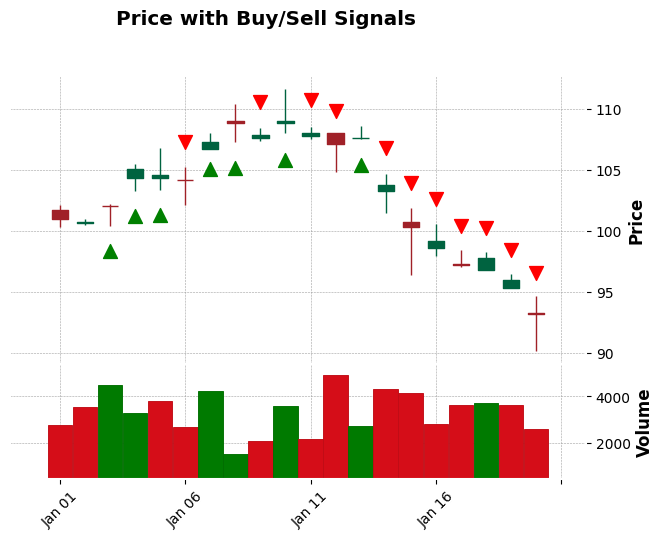

/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_29280/2306097932.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_29280/2306097932.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()



Tips:
- Use returnfig=True to get figure and axes for text annotations
- Text position uses index (0, 1, 2...) for x-axis
- Adjust y-position relative to High/Low for visibility
- Use bbox parameter for better text readability


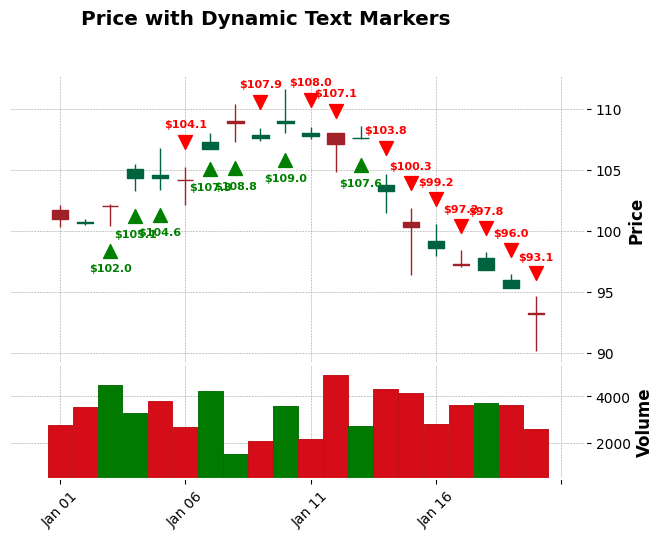

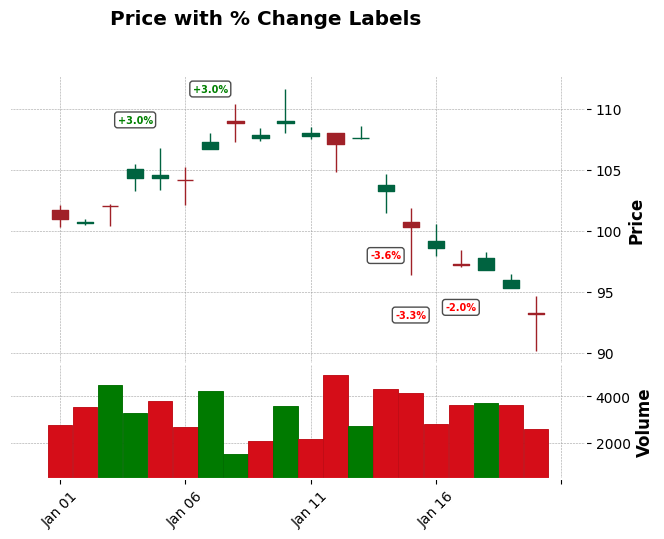

In [9]:
import mplfinance as mpf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Create sample OHLC data
dates = pd.date_range(start='2025-01-01', periods=20, freq='D')
np.random.seed(42)
close_prices = 100 + np.cumsum(np.random.randn(20) * 2)
data = pd.DataFrame({
    'Open': close_prices + np.random.randn(20) * 0.5,
    'High': close_prices + np.abs(np.random.randn(20) * 1.5),
    'Low': close_prices - np.abs(np.random.randn(20) * 1.5),
    'Close': close_prices,
    'Volume': np.random.randint(1000, 5000, 20)
}, index=dates)

# Method 1: Using scatter plot with text annotations
# Create signals where we want to add text
buy_signals = data['Close'] > data['Close'].rolling(3).mean()
sell_signals = data['Close'] < data['Close'].rolling(3).mean()

# Prepare data for markers - use where() to keep NaN for non-signals
buy_points = pd.Series(np.where(buy_signals, data['Low'] * 0.98, np.nan), 
                       index=data.index)
sell_points = pd.Series(np.where(sell_signals, data['High'] * 1.02, np.nan), 
                        index=data.index)

# Create addplot for markers
apds = [
    mpf.make_addplot(buy_points, type='scatter', markersize=100, 
                     marker='^', color='green'),
    mpf.make_addplot(sell_points, type='scatter', markersize=100, 
                     marker='v', color='red')
]

# Method 2: Using custom panel with text
# To add actual text, we need to use a custom panel
def add_text_markers(data, ax):
    """Add text annotations to the chart."""
    for i, (idx, row) in enumerate(data.iterrows()):
        if buy_signals.iloc[i]:
            ax[0].text(i, row['Low'] * 0.97, f'${row["Close"]:.1f}', 
                      ha='center', va='top', fontsize=8, 
                      color='green', weight='bold')
        if sell_signals.iloc[i]:
            ax[0].text(i, row['High'] * 1.03, f'${row["Close"]:.1f}', 
                      ha='center', va='bottom', fontsize=8, 
                      color='red', weight='bold')

# Basic plot with markers only
print("Plotting chart with markers...")
mpf.plot(data, type='candle', style='charles', volume=True, 
         addplot=apds, title='Price with Buy/Sell Signals')

# Plot with text annotations
fig, axes = mpf.plot(data, type='candle', style='charles', volume=True,
                     addplot=apds, title='Price with Dynamic Text Markers',
                     returnfig=True)
add_text_markers(data, axes)
fig.show()

# Method 3: Advanced - Text with custom values
# Add percentage change as text
def add_pct_change_text(data, ax):
    """Add percentage change text at key points."""
    pct_change = data['Close'].pct_change() * 100
    
    for i, (idx, row) in enumerate(data.iterrows()):
        if i > 0 and abs(pct_change.iloc[i]) > 2:  # Significant moves
            color = 'green' if pct_change.iloc[i] > 0 else 'red'
            y_pos = row['High'] * 1.03 if pct_change.iloc[i] > 0 else row['Low'] * 0.97
            va = 'bottom' if pct_change.iloc[i] > 0 else 'top'
            
            ax[0].text(i, y_pos, f'{pct_change.iloc[i]:+.1f}%', 
                      ha='center', va=va, fontsize=7, 
                      color=color, weight='bold',
                      bbox=dict(boxstyle='round,pad=0.3', 
                               facecolor='white', alpha=0.7))

# Method 4: Text on VOLUME panel (ax[1])
def add_volume_text(data, ax):
    """Add text to volume panel."""
    high_vol_idx = data['Volume'].nlargest(3).index
    
    for i, (idx, row) in enumerate(data.iterrows()):
        if idx in high_vol_idx:
            # ax[1] is the volume panel
            ax[1].text(i, row['Volume'], f'{row["Volume"]:,.0f}', 
                      ha='center', va='bottom', fontsize=7, 
                      color='blue', weight='bold',
                      bbox=dict(boxstyle='round,pad=0.2', 
                               facecolor='yellow', alpha=0.5))

# Method 5: Text on CUSTOM PANEL
# Add RSI indicator and text
rsi_period = 14
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

def add_rsi_text(data, rsi, ax):
    """Add text to RSI panel (custom panel)."""
    for i, (idx, val) in enumerate(rsi.items()):
        if pd.notna(val):
            if val > 70:  # Overbought
                # ax[2] is the RSI panel (first custom panel)
                ax[2].text(i, val, 'OB', ha='center', va='bottom', 
                          fontsize=6, color='red', weight='bold')
            elif val < 30:  # Oversold
                ax[2].text(i, val, 'OS', ha='center', va='top', 
                          fontsize=6, color='green', weight='bold')

fig2, axes2 = mpf.plot(data, type='candle', style='charles', volume=True,
                       title='Price with % Change Labels',
                       returnfig=True)
add_pct_change_text(data, axes2)
fig2.show()

# Plot with text on volume panel
fig3, axes3 = mpf.plot(data, type='candle', style='charles', volume=True,
                       title='Chart with Volume Labels',
                       returnfig=True)
add_volume_text(data, axes3)
fig3.show()

# Plot with custom RSI panel and text
rsi_plot = mpf.make_addplot(rsi, panel=2, color='purple', ylabel='RSI')
fig4, axes4 = mpf.plot(data, type='candle', style='charles', volume=True,
                       addplot=rsi_plot,
                       title='Chart with RSI Panel Text',
                       returnfig=True)
add_rsi_text(data, rsi, axes4)
# Add horizontal lines to RSI panel
axes4[2].axhline(70, color='red', linestyle='--', alpha=0.5)
axes4[2].axhline(30, color='green', linestyle='--', alpha=0.5)
fig4.show()

print("\nTips:")
print("- Use returnfig=True to get figure and axes for text annotations")
print("- Text position uses index (0, 1, 2...) for x-axis")
print("- Adjust y-position relative to High/Low for visibility")
print("- Use bbox parameter for better text readability")
print("\nPanel indices:")
print("- ax[0] = Main price panel")
print("- ax[1] = Volume panel (if volume=True)")
print("- ax[2+] = Custom panels (panel=2, panel=3, etc.)")